# [Práctica 2 - Clasificación](https://www.kaggle.com/competitions/ml-22-23-p2)

## Carga de los datos de entrenamiento
Lo primero que realizamos es la carga del dataset con el conjunto de datos que serán utilizados para entrenar el modelo.

In [1]:
!pip install -U imbalanced-learn
!pip install nevergrad

In [2]:
import numpy as np
import pandas as pd
import sklearn.compose

data = pd.read_csv("./Data/train.csv")
data.tail()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
79995,42636,39869,7,Hendrik Sackmannb,50.0,217529489.0,Media_Manager,107761.29,9047.107500,4.0,...,Standard,34.09,41.899992,211.0,Yes,0.000000,150.220682,High_spent_Large_value_payments,984.123010,Standard
79996,114031,38305,2,Alexj,33.0,98861902.0,Scientist,16218.32,1098.526667,6.0,...,Bad,4466.33,24.275710,98.0,NM,64.533114,34.457893,High_spent_Small_value_payments,260.523798,Poor
79997,85991,9976,6,Luciana Lopezi,25.0,745835485.0,Engineer,29374.77,2377.897500,3.0,...,Standard,1189.37,38.439021,241.0,NM,40.264074,22.234178,High_spent_Medium_value_payments,403.980355,Standard
79998,21240,13193,7,Edward Krudyd,15.0,894419091.0,Manager,43782.45,3543.537500,6.0,...,Bad,3468.25,24.233841,85.0,Yes,240.664739,42.839562,Low_spent_Large_value_payments,146.741586,Poor
79999,73558,15294,5,Neilp,30.0,17531609.0,Lawyer,102215.61,8482.967500,2.0,...,Good,79.67,27.903216,366.0,No,60.567361,60.971467,Low_spent_Medium_value_payments,355.384222,Good


## Preprocesamiento

### Simplificación de features
Crearemos una función para aplicar el preprocesamiento de la misma manera, tanto al dataframe del entrenamiento como al de test.

Esta función recibe por parámetro el dataframe sin la variable objetivo y nos devuelve otro dataframe con el preprocesamiento aplicado, para este preprocesamiento:
- Seperamos el array de Type of Loan creando una columna por cada uno de los valores del array y se le asigna a cada fila true o false según si estaba o no. 
- En Payment_Behaviour hacemos más simples las etiquetas y las semparamos en dos columnas, una para el valor de spent y otra para value payments
- Por último, eliminamos las columnas que no aportan nada. (ej. Ids, columnas que se han separado...)


In [3]:
def preprocess(data: pd.DataFrame):
    pd.options.mode.chained_assignment = None
    # Type of Loan
    def unique_types_loan(column: pd.Series):
        return list(set([type.strip() for type in [type for loan in [loan.split("and") for loan in [type.strip() for loan in column.str.split(',') for type in loan if type]] for type in loan if type]]))

    unique_types = unique_types_loan(data.Type_of_Loan)
    for type in unique_types:
        data[type] = data.Type_of_Loan.str.contains(type, regex=False)

    data["No Data"][(data["Not Specified"] == True)] = True

    # Payment Behaviour
    data = data.replace({'Payment_Behaviour': '_spent_'}, {
                        'Payment_Behaviour': ' '}, regex=True)
    data = data.replace({'Payment_Behaviour': '_value_payments'}, {
                        'Payment_Behaviour': ''}, regex=True)

    # Separar en dos columnas
    data["PB_Amount_Spent"] = data["Payment_Behaviour"].str.split().str[0]
    data["PB_Type_Payments"] = data["Payment_Behaviour"].str.split().str[1]
    
    data = data.drop(["ID", "Customer_ID", "Month", "Name",
                     "SSN", "Occupation", "Type_of_Loan", "Not Specified"], axis=1)

    return data

### Separar la variable objetivo
Con la anterior función definida, separamos la variable objetivo y aplicamos el preprocesamiento al resto de dataframe.

In [4]:
y_data = data.iloc[:, -1]
X_data = preprocess(data.iloc[:, 0:-1])


X_data


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,No Data,Home Equity Loan,Mortgage Loan,Payday Loan,Auto Loan,Debt Consolidation Loan,Personal Loan,Student Loan,PB_Amount_Spent,PB_Type_Payments
0,40.0,97384.44,8167.370000,1.0,3.0,8.0,1.0,20.0,12.0,0.52,...,False,False,False,False,False,True,False,False,High,Large
1,39.0,31369.58,2607.131667,8.0,9.0,27.0,8.0,30.0,25.0,19.70,...,True,True,True,False,False,False,True,False,High,Large
2,17.0,30171.86,2772.321667,6.0,7.0,30.0,9.0,49.0,18.0,23.49,...,False,True,True,False,False,False,True,True,High,Large
3,22.0,13100.02,1246.668333,7.0,5.0,6.0,5.0,6.0,20.0,10.64,...,True,True,False,False,False,True,False,False,Low,Large
4,26.0,62313.54,5120.795000,6.0,2.0,18.0,4.0,27.0,8.0,12.82,...,False,False,False,True,True,False,False,True,Low,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,50.0,107761.29,9047.107500,4.0,5.0,9.0,0.0,7.0,19.0,14.56,...,True,False,False,False,False,False,False,False,High,Large
79996,33.0,16218.32,1098.526667,6.0,6.0,21.0,5.0,44.0,19.0,8.98,...,False,True,True,False,False,False,True,False,High,Small
79997,25.0,29374.77,2377.897500,3.0,7.0,6.0,2.0,23.0,13.0,16.65,...,False,False,False,True,False,False,False,True,High,Medium
79998,15.0,43782.45,3543.537500,6.0,9.0,25.0,8.0,32.0,16.0,1.88,...,True,True,False,True,True,False,True,False,Low,Large


### Análisis de las features

Mostramos un gráfico para ver las distribuciones de la densidad de las features.

array([[<AxesSubplot:title={'center':'Age'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Annual_Income'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Monthly_Inhand_Salary'}, ylabel='Density'>],
       [<AxesSubplot:title={'center':'Num_Bank_Accounts'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Num_Credit_Card'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Interest_Rate'}, ylabel='Density'>],
       [<AxesSubplot:title={'center':'Num_of_Loan'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Delay_from_due_date'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Num_of_Delayed_Payment'}, ylabel='Density'>],
       [<AxesSubplot:title={'center':'Changed_Credit_Limit'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Num_Credit_Inquiries'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Outstanding_Debt'}, ylabel='Density'>],
       [<AxesSubplot:title={'center':'Credit_Utilization_Ratio'}, ylabel='

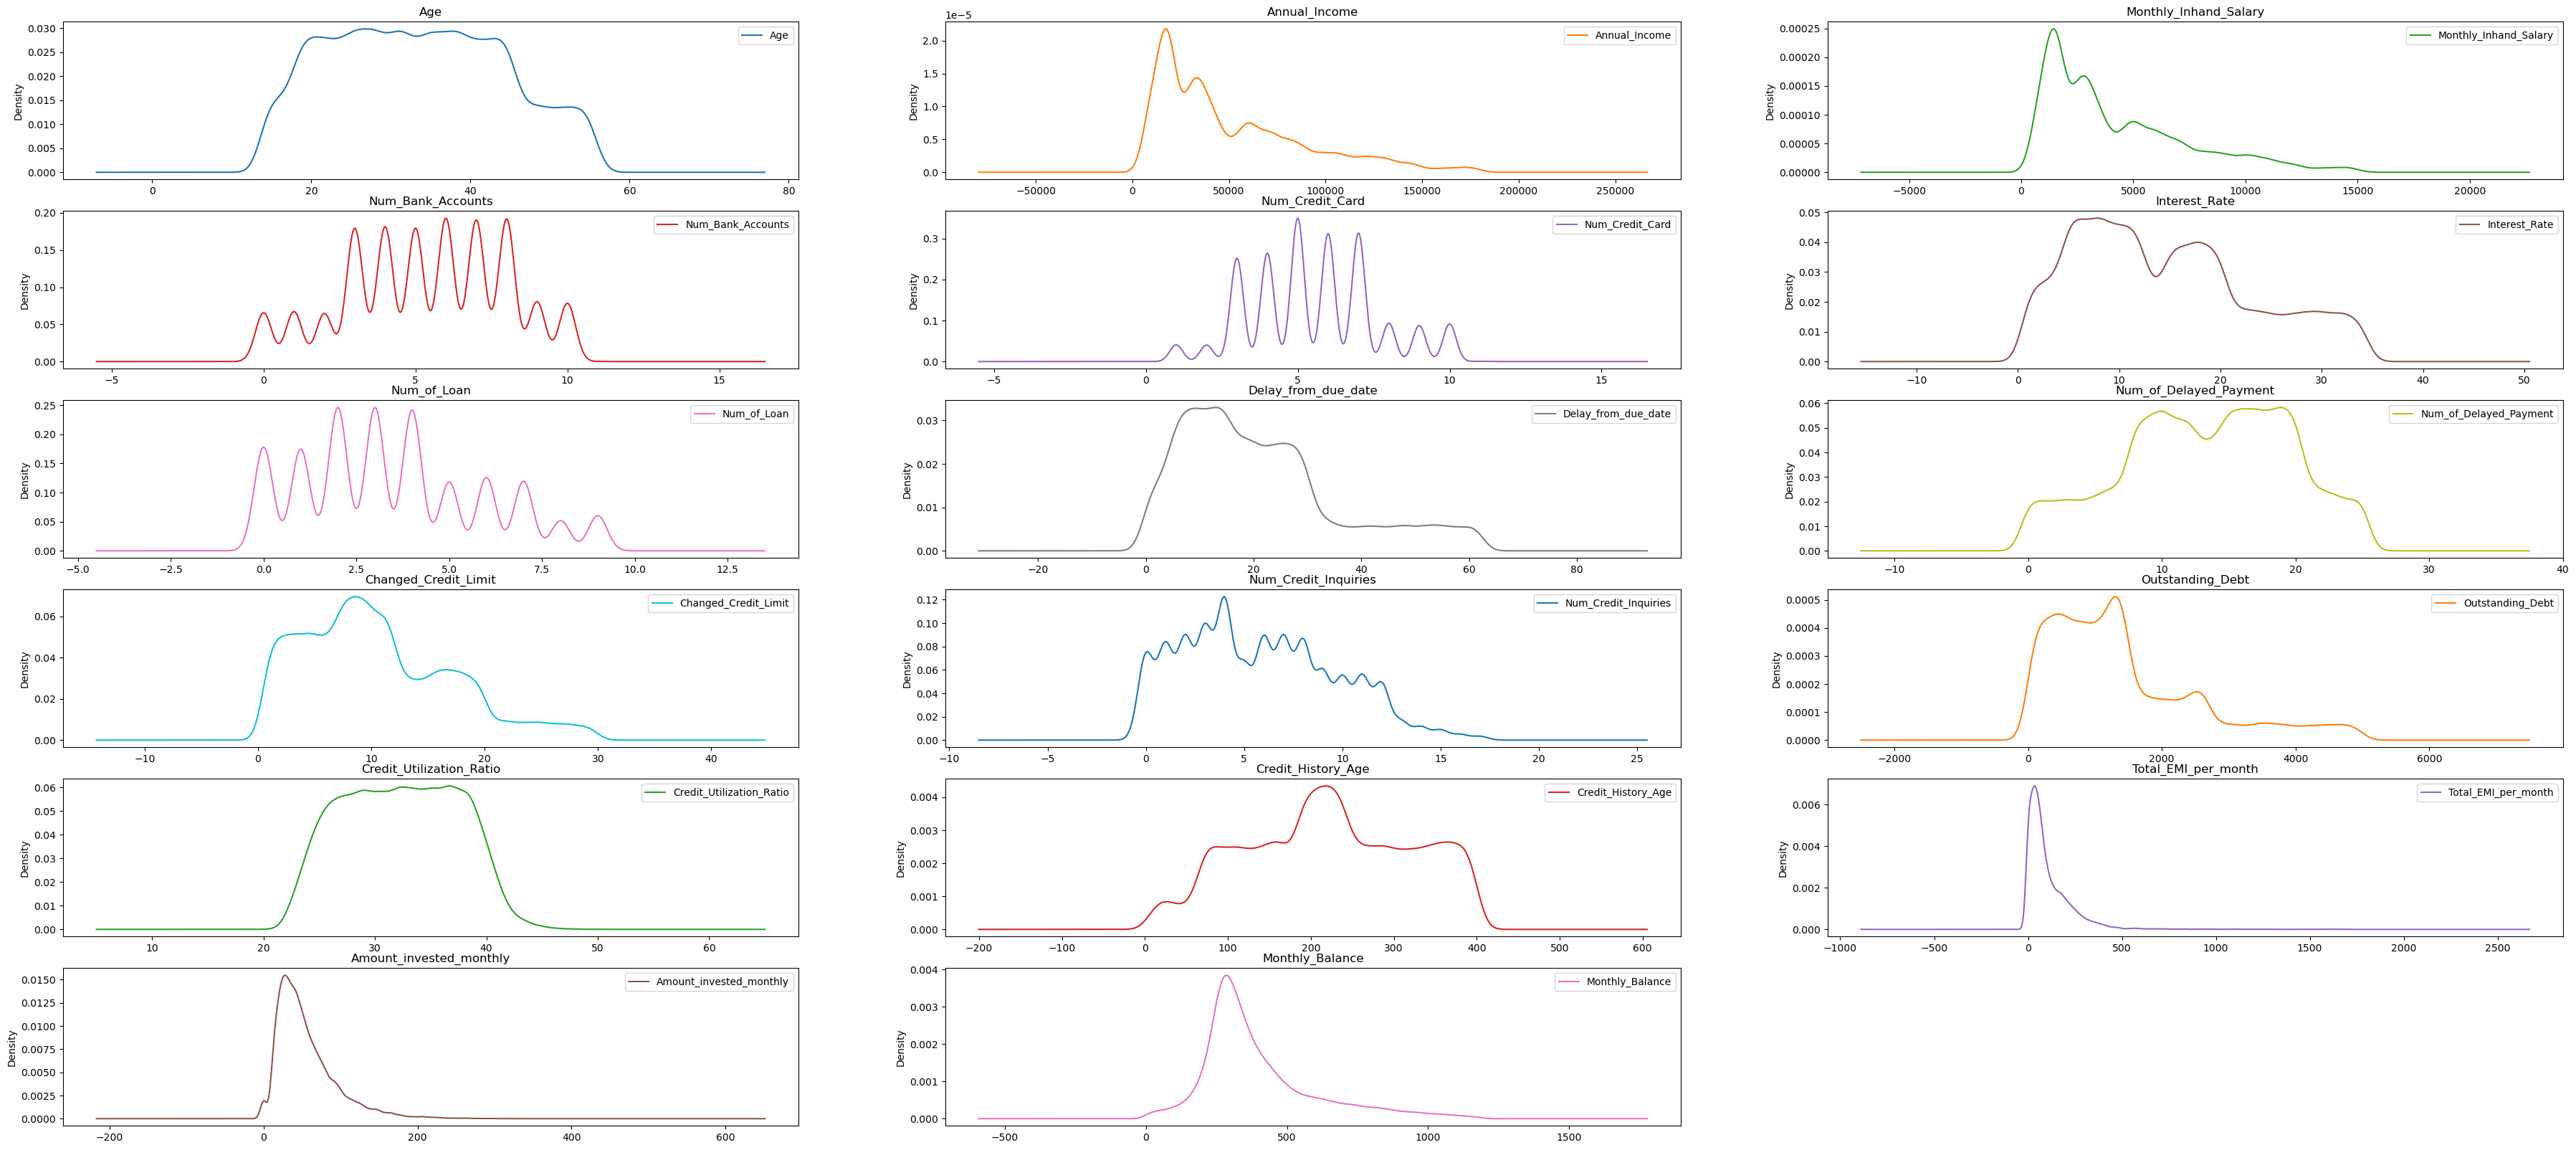

In [5]:
columns = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date", 
    "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Outstanding_Debt", "Credit_Utilization_Ratio", "Credit_History_Age",
    "Total_EMI_per_month", "Amount_invested_monthly", "Monthly_Balance"]

df_kde_box = X_data[columns]
    
df_kde_box.plot(kind='kde', subplots=True, figsize=(45, 20), sharex=False, sharey=False, layout=(6, 3), title=columns)


### Transformación de las features

Para la normalización de las features:

- En las variables discretas se utilizará el OneHotEncoder con el handle_unknown en ignore para que cuando reciba un valor desconocido, mantenga las columnas implicadas a 0 sin lanzar una excepción. Lo positivo del OneHotEncoder es que no da más peso a unos valores que a otros, pero crea muchas columnas cuando una feature tiene muchos valores.
- En las variables continuas hemos usado el MinMaxScaler o el StandardScaler.

In [6]:
X_data.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit-Builder Loan', 'No Data', 'Home Equity Loan', 'Mortgage Loan',
       'Payday Loan', 'Auto Loan', 'Debt Consolidation Loan', 'Personal Loan',
       'Student Loan', 'PB_Amount_Spent', 'PB_Type_Payments'],
      dtype='object')

In [7]:
from sklearn.preprocessing import *

ct = sklearn.compose.ColumnTransformer(transformers=[
    ("Age", StandardScaler(), [0]),
    ("Annual_Income", MinMaxScaler(), [1]),
    ("Monthly_Inhand_Salary", MinMaxScaler(), [2]),
    ("Num_Bank_Accounts", OneHotEncoder(handle_unknown='ignore'), [3]),
    ("Num_Credit_Card", OneHotEncoder(handle_unknown='ignore'), [4]),
    ("Interest_Rate", MinMaxScaler(), [5]),
    ("Num_of_Loan", OneHotEncoder(handle_unknown='ignore'), [6]),
    ("Delay_from_due_date", MinMaxScaler(), [7]),
    ("Num_of_Delayed_Payment", MinMaxScaler(), [8]),
    ("Changed_Credit_Limit", MinMaxScaler(), [9]),
    ("Num_Credit_Inquiries", OneHotEncoder(handle_unknown='ignore'), [10]),
    ("Credit_Mix", OneHotEncoder(handle_unknown='ignore'), [11]),
    ("Outstanding_Debt", MinMaxScaler(), [12]),
    ("Credit_Utilization_Ratio", StandardScaler(), [13]),
    ("Credit_History_Age", StandardScaler(), [14]),
    ("Payment_of_Min_Amount", OneHotEncoder(handle_unknown='ignore'), [15]),
    ("Total_EMI_per_month", MinMaxScaler(), [16]),
    ("Amount_invested_monthly", MinMaxScaler(), [17]),
    ("Payment_Behaviour", 'drop', [18]),
    ("Monthly_Balance", MinMaxScaler(), [19]),
    ("Credit-Builder Loan", OneHotEncoder(handle_unknown='ignore'), [20]),
    ("No Data", OneHotEncoder(handle_unknown='ignore'), [21]),
    ("Payday Loan", OneHotEncoder(handle_unknown='ignore'), [22]),
    ("Personal Loan", OneHotEncoder(handle_unknown='ignore'), [23]),
    ("Home Equity Loan", OneHotEncoder(handle_unknown='ignore'), [24]),
    ("Student Loan", OneHotEncoder(handle_unknown='ignore'), [25]),
    ("Auto Loan", OneHotEncoder(handle_unknown='ignore'), [26]),
    ("Mortgage Loan", OneHotEncoder(handle_unknown='ignore'), [27]),
    ("Debt Consolidation Loan", OneHotEncoder(handle_unknown='ignore'), [28]),
    ("PB_Amount_Spent", OneHotEncoder(handle_unknown='ignore'), [29]),
    ("PB_Type_Payments", OneHotEncoder(handle_unknown='ignore'), [30])
])

X = pd.DataFrame(ct.fit_transform(X_data))
lb = LabelEncoder()
y = lb.fit_transform(y_data)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
0,80000.0,-5.321854e-17,1.000006,-1.794644,-0.865588,-0.029437,0.806714,2.107392
1,80000.0,2.519339e-01,0.221962,0.000000,0.071298,0.173806,0.374090,1.000000
2,80000.0,2.617462e-01,0.214388,0.000000,0.088713,0.187754,0.380088,1.000000
3,80000.0,4.465000e-02,0.206535,0.000000,0.000000,0.000000,0.000000,1.000000
4,80000.0,4.561250e-02,0.208645,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
89,80000.0,4.631750e-01,0.498645,0.000000,0.000000,0.000000,1.000000,1.000000
90,80000.0,5.368250e-01,0.498645,0.000000,0.000000,1.000000,1.000000,1.000000
91,80000.0,2.559875e-01,0.436418,0.000000,0.000000,0.000000,1.000000,1.000000
92,80000.0,3.409000e-01,0.474015,0.000000,0.000000,0.000000,1.000000,1.000000


## Comprobación de desbalanceamiento

Miramos como se distribuyena las clases de  nuestro dataframe. Se puede observar que hay una clase que es significativamente más grande que las otras dos, y hay una que bastante menos muestras comparada con las otras dos.

Class 0: 14262
Class 1: 23199
Class 2: 42539
Total: 80000


<AxesSubplot:title={'center':'Count (target)'}>

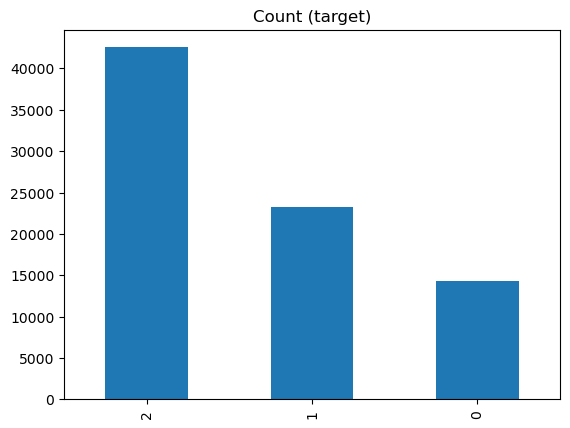

In [8]:
target_count = pd.Series(y).value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Total:', y.shape[0])
pd.Series(y).value_counts().plot(kind='bar', title='Count (target)')

Para tratar de reducir está diferencia usamos la técnica de oversampling, en este caso SMOTETomek, que aplicará primero un SMOTE a la clase con menor representación y por último aplicará TomekLinks para reducir el número de entradas sintéticas recien creadas. 
Comprobamos como ahora las clases están balanceadas.

Class 0: 41873
Class 1: 40869
Class 2: 40217
Total: 122959


<AxesSubplot:title={'center':'Count (target)'}>

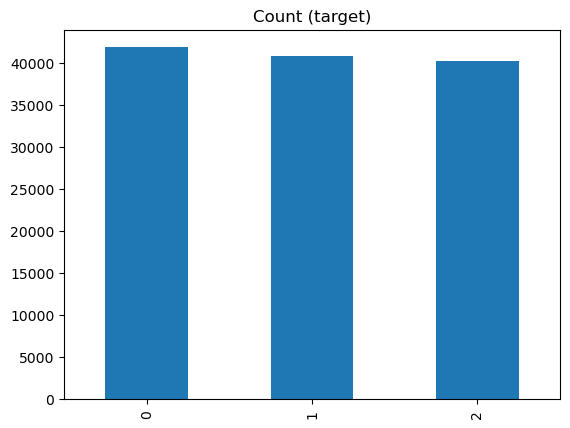

In [9]:
from imblearn.combine import SMOTETomek

smote = SMOTETomek(random_state=42, n_jobs=-1)
X_balanced, y_balanced = smote.fit_resample(X, y)

target_count = pd.Series(y_balanced).value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Total:', y_balanced.shape[0])

target_count.plot(kind='bar', title='Count (target)')

## Elección de clasificadores

Hemos estado probando diferentes clasificadores, así como sus respectivos métodos para buscar hiperparámetros.
- KNN no resulto muy eficaz
- Random forest no mejora cambiando hiperparámetros.
- HistogradientBoosting y Gradient boosting tiene resultados parecidos pero no alcanzan al XGBoost
- Probamos usando un stacking con/sin passthrough y no mejoró tampoco al probar con el test.
- Lo que mejor resultados dio fue usar XGBoost

In [21]:
from datetime import datetime

def timer(start_time=None, reg=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        if reg:
            print(reg + ' took: %i hours %i minutes and %s seconds.' %
                  (thour, tmin, round(tsec, 2)))
        else:
            print('Time taken: %i hours %i minutes and %s seconds.' %
                  (thour, tmin, round(tsec, 2)))


In [23]:
from sklearn.ensemble import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)

# Set up score
scoring = 'f1_weighted'
scores = {
    scoring: []
}

# Set up the k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up classifiers
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
svc = SVC(kernel='rbf', probability=True, random_state=42)
sclf_pass_false = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=False)
sclf_pass_true = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=True)
vc = VotingClassifier(estimators=[('rf', rf), ('knn', knn)])
bag = BaggingClassifier(rf, n_estimators=10, max_samples=0.05, random_state=42, n_jobs=-1)
adaboost = AdaBoostClassifier(n_estimators=10, random_state=42)
gb = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, criterion='squared_error', max_depth=1, random_state=42)
xgboost = XGBClassifier(n_estimators=500, objective='multi:softprob', num_class=3, tree_method='gpu_hist', eval_metric='auc', random_state=42, n_jobs=-1)

regs = {
    "RandomForest": rf,
    "KNN": knn,
    "VotingClassifier": vc,
    "BaggingClassifier": bag,
    "AdaBoostClassifier": adaboost,
    "GradientBoosting": gb,
    "XGBoostClassifier": xgboost,
    "Stacking_con_passthrough": sclf_pass_true,
    "Stacking_sin_passthrough": sclf_pass_false
}

for reg_name, reg in regs.items():
    start_time = timer()
    reg.fit(X_balanced, y_balanced)
    score = np.mean(cross_val_score(reg, X_balanced, y_balanced, cv=skf, scoring=scoring, verbose=3, n_jobs=-1))
    scores["f1_weighted"].append(score)
    timer(start_time, reg=reg_name)

scores = pd.DataFrame(scores, index=regs.keys())

scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


RandomForest took: 0 hours 0 minutes and 12.93 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


KNN took: 0 hours 0 minutes and 12.19 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


VotingClassifier took: 0 hours 0 minutes and 23.59 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


BaggingClassifier took: 0 hours 0 minutes and 17.72 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


AdaBoostClassifier took: 0 hours 0 minutes and 4.7 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


GradientBoosting took: 0 hours 0 minutes and 9.8 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.5s finished


XGBoostClassifier took: 0 hours 0 minutes and 51.94 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Stacking_con_passthrough took: 0 hours 3 minutes and 21.46 seconds.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Stacking_sin_passthrough took: 0 hours 1 minutes and 47.66 seconds.


,f1_weighted
RandomForest,0.886369
KNN,0.855579
VotingClassifier,0.849672
BaggingClassifier,0.751385
AdaBoostClassifier,0.711580
GradientBoosting,0.721935
XGBoostClassifier,0.893186
Stacking_con_passthrough,0.906804
Stacking_sin_passthrough,0.900364


### Búsqueda de hiperparámetros

Después de ver los resultados con el dataframe de test, realizamos la optimización de hiperparámetros para el XGBoost Classifier aprovechando la posibilidad de este clasificador de utilizar la GPU para reducir los tiempos de entrenamiento y búsqueda.

> ⚠️ Debido al alto consumo de recursos en la optimización de hiperparámetros el siguiente código será mostrado pero no ejecutado en una celda

#### XGBoost Classifier sin optimización de hiperparámetros
Partimos del caso base con los hiperparámetros mínimos para activar el uso de la GPU y los necesarios para nuestro problema de clasificación de 3 clases.

```python
start_time = timer()
cv = cross_val_score(xgboost, X_balanced, y_balanced, cv=skf, scoring=scoring, verbose=3, n_jobs=-1)
timer(start_time)
# Print result
print("XGBoost Classifier With No Hyperparameter Tuning: " + ', '.join(f'{score:.5f}' for score in cv))
xgboost.fit(X_balanced,y_balanced)
```

```log
OUTPUT:
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.5s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.9s finished
Time taken: 0 hours 0 minutes and 46.01 seconds.
XGBoost Classifier With No Hyperparameter Tuning: 0.89251, 0.89187, 0.89656, 0.89076, 0.89173
```

#### XGBoost Classifier con GridSearchCV
Una vez establecido el regresor base, probamos con un GridSearchCV con una baja variedad de parámetros a optimizar a fin de reducir el tiempo de cómputo.

```python
# A parameter grid for XGBoost
param_grid = {
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [0.3, 0.5, 0.8],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
}

# Define grid search
grid_search = GridSearchCV(estimator=xgboost,
                           param_grid=param_grid,
                           scoring=scoring,
                           refit=scoring,
                           n_jobs=-1,
                           cv=skf,
                           verbose=3)
# Fit grid search
start_time = timer()
grid_result = grid_search.fit(X_balanced, y_balanced)
timer(start_time)
# Print grid search summary
print(grid_result)
print(grid_result.best_score_)
print(grid_result.best_params_)
```

```log
OUTPUT:
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Time taken: 0 hours 34 minutes and 3.61 seconds.
{'colsample_bytree': 0.8, 'reg_alpha': 1, 'reg_lambda': 0.5}
0.8935518772668034
```

#### XGBoost Classifier con RandomizedSearchCV
Gracias al RandomizedSearchCV podemos aumentar el número de parámetros a optimizar aunque asumimos el riesgo de caer en una optimización local y no encontrar la solución más óptima.

```python
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0]
}

# Define random search
random_search = RandomizedSearchCV(estimator=xgboost, 
                                   param_distributions=param_grid, 
                                   n_iter=48,
                                   scoring=scoring, 
                                   refit=scoring,
                                   n_jobs=-1, 
                                   cv=skf, 
                                   verbose=3)
# Fit grid search
start_time = timer()
random_result = random_search.fit(X_balanced, y_balanced)
timer(start_time)
# Print grid search summary
random_result
```

```log
OUTPUT:
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time taken: 3 hours 31 minutes and 24.38 seconds.
{'subsample': 0.8,
 'reg_lambda': 1,
 'reg_alpha': 0.01,
 'min_child_weight': 1,
 'max_depth': 18,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.3}
0.800439586280007
```

#### XGBoost Classifier con Optimización Bayesiana
Debido al alto coste computacional de optimizar tantos parámetros se ha optado por probar una optimización bayesiana.

```python
!pip install hyperopt

from sklearn.model_selection import cross_val_score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01, 0.1]),
    'max_depth': hp.choice('max_depth', range(3, 21, 3)),
    'gamma': hp.choice('gamma', [i/10.0 for i in range(0, 5)]),
    'colsample_bytree': hp.choice('colsample_bytree', [i/10.0 for i in range(3, 10)]),
    'reg_alpha': hp.choice('reg_alpha', [1e-2, 0.1, 1, 10, 100]),
    'reg_lambda': hp.choice('reg_lambda', [1e-2, 0.1, 1, 10, 100])
}

# Objective function
def objective(params):

    xgboost = XGBClassifier(n_estimators=500, 
                            objective='multi:softprob',
                            num_class=3, 
                            tree_method='gpu_hist', 
                            eval_metric='auc', 
                            random_state=42,
                            n_jobs=-1,
                            **params)
    scores = cross_val_score(xgboost, X, y, cv=skf, scoring='f1_weighted', n_jobs=-1)
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    loss = - best_score
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


# Trials to track progress
bayes_trials = Trials()
# Optimize
start_time = timer()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=24, trials=bayes_trials)
timer(start_time)
# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))
```

```log
OUTPUT:
100%|████████████████████████████████████████████| 24/24 [4:30:21<00:00, 675.88s/trial, best loss: -0.8091742172135046]
Time taken: 4 hours 30 minutes and 21.24 seconds.
{'colsample_bytree': 3, 'gamma': 3, 'learning_rate': 2, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 3}
{'colsample_bytree': 0.6, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 18, 'reg_alpha': 0.01, 'reg_lambda': 10}
```

Y una vez optimizados los parámetros mediante este método, lo probamos con un cross-validation.

```python
xgboost = XGBClassifier(n_estimators=500, 
                        objective='multi:softprob',
                        num_class=3, 
                        tree_method='gpu_hist', 
                        eval_metric='auc',
                        colsample_bytree=0.6,
                        gamma=0.3,
                        learning_rate=0.01,
                        max_depth=18,
                        reg_alpha=0.01,
                        reg_lambda=10,
                        random_state=42,
                        n_jobs=-1)

start_time = timer()
cv = cross_val_score(xgboost, X_balanced, y_balanced, cv=skf, scoring=scoring, verbose=3, n_jobs=-1)
timer(start_time)
# Print result
print("XGBoost Classifier With Bayesian Optimization Tuning: " + ', '.join(f'{score:.5f}' for score in cv))
```

```log
OUTPUT:
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
Time taken: 0 hours 54 minutes and 56.87 seconds.
XGBoost Classifier With Bayesian Optimization Tuning: 0.88136, 0.88078, 0.88075, 0.88356, 0.88152
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 54.9min finished
```

### Análisis de la búsqueda de hiperparámetros

Como se puede observar el *regresor 'base'* es bastante bueno en comparación con otras búsquedas más sofisticadas, teniendo un F1 medio de **0.893186** en comparación con la mejor optimización obtenida con el *GridSearchCV* con un F1 de **0.893551**. Seguidas por la *optimización bayesiana* con un F1 de **0.881594** y por el *RandomizedSearchCV* con un F1 de **0.800439**

| **Método de Optimización** | **F1** |
| :- | -: |
| GridSearchCV | 0.893551 |
| Sin optimización | 0.893186 |
| Optimización Bayesiana | 0.881594 |
| RandomizedSearchCV | 0.800439 |

## Asignación del clasificador
Tras la comparación de los clasificadores con los diferentes hiperparámetros, asignamos el clasificador y hacemos una partición equilibrada del 50% para su análisis con la matriz de confusión.

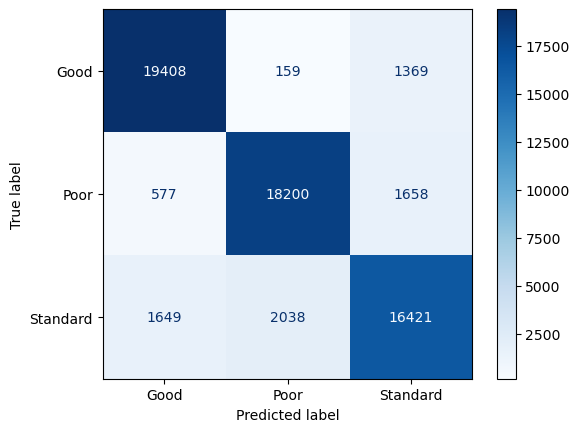

Balanceado: 0.8783763843666751


In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

xgboost = XGBClassifier(n_estimators=500,
                        objective='multi:softprob',
                        num_class=3,
                        tree_method='gpu_hist',
                        eval_metric='auc',
                        colsample_bytree=0.8,
                        reg_alpha=1,
                        reg_lambda=0.5,
                        random_state=42,
                        n_jobs=-1)

for train_idx, test_idx in skf.split(X_balanced, y_balanced):
    X_train_balanced, X_test_balanced = pd.DataFrame(X_balanced).iloc[train_idx], pd.DataFrame(X_balanced).iloc[test_idx]
    y_train_balanced, y_test_balanced = pd.DataFrame(y_balanced).iloc[train_idx], pd.DataFrame(y_balanced).iloc[test_idx]

xgboost.fit(X_train_balanced, y_train_balanced)

ConfusionMatrixDisplay.from_estimator(xgboost, X_test_balanced, y_test_balanced, display_labels=lb.classes_, cmap=plt.cm.Blues)

y_pred_balance = xgboost.predict(X_test_balanced)
plt.show()

y_pred= xgboost.predict(X_test)

print("Balanceado: " + str(metrics.f1_score(y_test_balanced, y_pred_balance, average='weighted')))

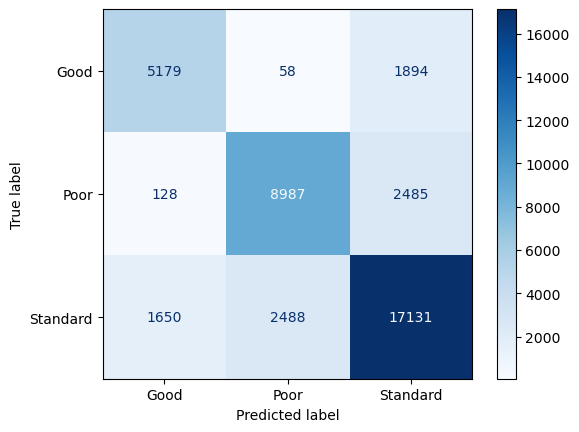

Desbalanceado: 0.7822621304198677


In [37]:
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = pd.DataFrame(X).iloc[train_idx], pd.DataFrame(X).iloc[test_idx]
    y_train, y_test = pd.DataFrame(y).iloc[train_idx], pd.DataFrame(y).iloc[test_idx]

xgboost.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(xgboost, X_test, y_test, display_labels=lb.classes_, cmap=plt.cm.Blues)
plt.show()

y_pred = xgboost.predict(X_test)

print("Desbalanceado: " + str(metrics.f1_score(y_test, y_pred, average='weighted')))


Como se puede ver se han sacado dos matrices de confusion, una para los datos balanceados y otra para los datos en la proporción en la que estaban originalmente, como se puede apreciar ambas tienen un mayor porcentaje de acierto para la clase correspondiente y en la matriz del desbalanceamiento se aprecia la proporción de los datos de cada clase.
Se observa que con los datos balanceados los errores se distribuyen en el resto de clases y no se agrupan en la clase mayoritaria.

# Predicción

In [38]:
test_data = pd.read_csv("./Data/test.csv")

id_test = test_data["ID"]

test_data = preprocess(test_data)

test_data = pd.DataFrame(ct.transform(test_data))

y_test_pred = xgboost.predict(test_data)
y_test_pred = lb.inverse_transform(y_test_pred)

prediction = pd.DataFrame()
prediction["ID"] = id_test
prediction["Credit_Score"] = y_test_pred

prediction.to_csv('./Data/prediction.csv', index=False)

prediction

,ID,Credit_Score
0,99246,Standard
1,90071,Good
2,64375,Poor
3,142441,Poor
4,135010,Poor
...,...,...
19995,126990,Good
19996,128347,Standard
19997,88941,Good
19998,89599,Standard
